In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import data_gen
import random
import gym
import numpy as np
import portfolio_env
from portfolio_env import PortfolioEnv

from stable_baselines3 import DDPG, PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from data_reader import bitcoin, gold, price

from model_evaluate import evaluate

In [2]:
bitcoin.head()

,Value
Date,
2016-09-11,621.65
2016-09-12,609.67
2016-09-13,610.92
2016-09-14,608.82
2016-09-15,610.38


In [3]:
gold.head()

,Value
2016-09-12,1324.60
2016-09-13,1323.65
2016-09-14,1321.75
2016-09-15,1310.80
2016-09-16,1308.35


<AxesSubplot:xlabel='Date'>

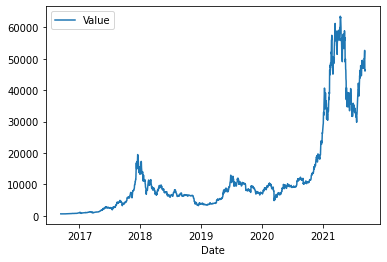

In [4]:
sns.lineplot(data=bitcoin)

<AxesSubplot:>

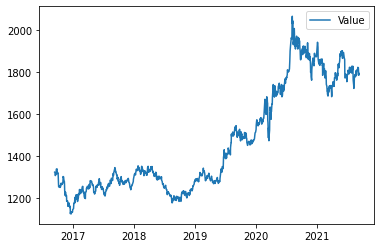

In [5]:
sns.lineplot(data=gold)

In [6]:
price

,gold,bitcoin
2016-09-12,1324.60,609.67
2016-09-13,1323.65,610.92
2016-09-14,1321.75,608.82
2016-09-15,1310.80,610.38
2016-09-16,1308.35,609.11
...,...,...
2021-09-06,1821.60,51769.06
2021-09-07,1802.15,52677.40
2021-09-08,1786.00,46809.17
2021-09-09,1788.25,46078.38


In [7]:
index = gold.index[0] + pd.DateOffset(n=1)

price.loc[index: index + pd.DateOffset(n=15)]

pd.notna(gold)[1:]

,Value
2016-09-13,True
2016-09-14,True
2016-09-15,True
2016-09-16,True
2016-09-17,False
...,...
2021-09-06,True
2021-09-07,True
2021-09-08,True
2021-09-09,True


In [8]:
cur_date = pd.Timestamp('2016-9-22')

price.loc[cur_date - pd.DateOffset(n=10): cur_date]

,gold,bitcoin
2016-09-12,1324.60,609.67
2016-09-13,1323.65,610.92
2016-09-14,1321.75,608.82
2016-09-15,1310.80,610.38
2016-09-16,1308.35,609.11
2016-09-17,1308.35,607.04
2016-09-18,1308.35,611.58
2016-09-19,1314.85,610.19
2016-09-20,1313.80,608.66
2016-09-21,1326.10,598.88


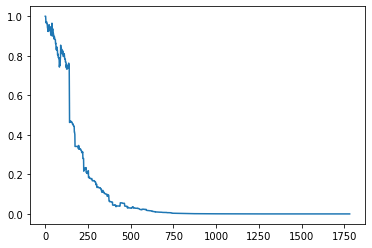

In [9]:
env = PortfolioEnv(price, pd.notna(gold)['Value'], pd.Timestamp('2016-9-12'), pd.Timestamp('2021-9-8'))
rewards = []
bit = []
while True:
    action = env.action_space.sample()
    _, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        break

rewards = np.array(rewards)
rewards = rewards.cumsum()
rewards = np.exp(rewards)
plt.plot(rewards)
# plt.plot(bit)

del rewards

In [10]:


# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1000000, log_interval=20)
model.save("ppo-1000000")
env = model.get_env()


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.78e+03     |
|    ep_rew_mean          | 0.915        |
| time/                   |              |
|    fps                  | 478          |
|    iterations           | 20           |
|    time_elapsed         | 85           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0078110704 |
|    clip_fraction        | 0.0781       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.42        |
|    explained_variance   | 0.0075       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0225      |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00553     |
|    std                  | 0.934        |
|    value_loss           | 0.00388      |
--

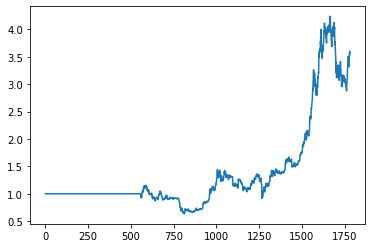

In [19]:

del model # remove to demonstrate saving and loading

model = PPO.load("ppo-10000")

res = []
best = 0
for i in range(300):
    r = evaluate(model, env)
    if r.max() > best:
        best = r.max()
        res = r

plt.plot(res)


In [12]:
res.dump('../save/ppo-1000000-5.npy')